# Training Notebook for VQ-VAE
To be run using on the Google Colab servers

### Global setup

In [10]:
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import strftime

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Connect to Github repository and import code

In [2]:
# RUN THIS ONCE AT THE START OF THE SESSION
# clone github repository
!git clone --single-branch --branch modern https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen.git

# add repo to sys path to allow imports
import sys
sys.path.append('/content/VQ-VAE-Tranformer-Image-Gen')

Cloning into 'VQ-VAE-Tranformer-Image-Gen'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 324 (delta 85), reused 97 (delta 72), pack-reused 212 (from 1)
Receiving objects: 100% (324/324), 179.80 MiB | 51.30 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [11]:
# RUN THIS AT THE START AS WELL AS EVERY TIME THE REPO IS UPDATED
# pull changes from github
%cd /content/VQ-VAE-Tranformer-Image-Gen
!git pull origin modern

# refrsh the imports
from importlib import reload
import VQ.model
reload(VQ.model)

from VQ.model import Encoder, Decoder, Quantizer, VQ_VAE, LATENT_W, LATENT_H, IMG_H, IMG_W, NUM_EMBEDDINGS, EMBEDDING_DIM

/content/VQ-VAE-Tranformer-Image-Gen
From https://github.com/patrickmastorga/VQ-VAE-Tranformer-Image-Gen
 * branch            modern     -> FETCH_HEAD
Already up to date.


### Load CelebA dataset

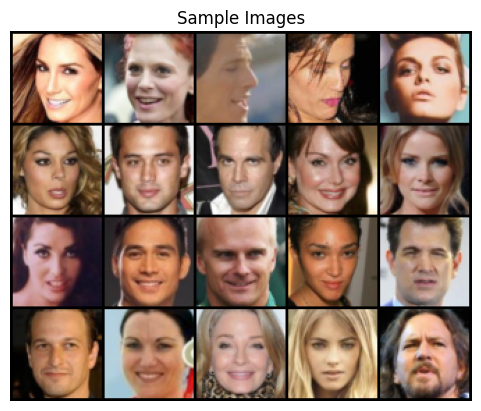

In [12]:
# access the kaggle.json API key from the main folder of your google drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from kaggle
!kaggle datasets download -d zuozhaorui/celeba
!mkdir ./data
!unzip -q celeba.zip -d ./data/celeba

# load dataset using ImageFolder dataset
class CelebATransform:
    '''
    Crops around the face and resizes to IMG_HxIMG_W. Output is a tensor of shape (3, IMG_H, IMG_W) scaled to [0, 1]
    '''
    def __call__(self, img):
        img = torchvision.transforms.functional.crop(img, top=60, left=25, height=128, width=128)
        img = torchvision.transforms.functional.resize(img, (IMG_H, IMG_W))
        img = torchvision.transforms.functional.to_tensor(img)
        # img = torchvision.transforms.functional.normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        return img
celeba = torchvision.datasets.ImageFolder(root='./data/celeba', transform=CelebATransform())

# visualize
grid_x = 5
grid_y = 4

samples = torch.stack([celeba[i][0] for i in range(grid_x*grid_y)])

img = torchvision.utils.make_grid(samples, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Sample Images')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())

### Initialize Model and dataloader

In [13]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataloader = torch.utils.data.DataLoader(celeba, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
encoder = Encoder()
decoder = Decoder()
quantizer = Quantizer(batch_size=BATCH_SIZE)
vq_vae = VQ_VAE(encoder, decoder, quantizer).to(device)

### Pretrain for one epoch without quantization

In [27]:
# training hyperparameters
EPOCHS = 1
LEARNING_RATE = 2e-4
LOG_INTERVAL = 100

# optmizer and training state vars
optimizer = torch.optim.Adam([
    {'params': encoder.parameters(), 'lr': LEARNING_RATE},
    {'params': decoder.parameters(), 'lr': LEARNING_RATE},
])
running_loss = 0.0

# training loop
print(f'{strftime('%H:%M:%S')} Begin Pretraining')
encoder.train()
decoder.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        images, _ = batch
        images = images.to(device)

        z_e = encoder(images)
        reconstructed = decoder(z_e)

        loss = nn.functional.l1_loss(reconstructed, images)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging step
        if (batch_idx + 1) % LOG_INTERVAL == 0:
            avg_loss = running_loss / LOG_INTERVAL
            running_loss = 0.0
            print(f'{strftime('%H:%M:%S')} PRETRAINING Epoch [{epoch}/{EPOCHS}] Step [{batch_idx + 1}/{len(dataloader)}]; Reconstruction: {avg_loss:.6f}')
print(f'{strftime('%H:%M:%S')} Pretraining complete.')

16:01:30 Begin Pretraining
16:02:10 PRETRAINING Epoch [0/1] Step [100/1583]; Reconstruction: 0.109908
16:02:49 PRETRAINING Epoch [0/1] Step [200/1583]; Reconstruction: 0.038961
16:03:29 PRETRAINING Epoch [0/1] Step [300/1583]; Reconstruction: 0.029805
16:04:09 PRETRAINING Epoch [0/1] Step [400/1583]; Reconstruction: 0.025287
16:04:50 PRETRAINING Epoch [0/1] Step [500/1583]; Reconstruction: 0.023079
16:05:30 PRETRAINING Epoch [0/1] Step [600/1583]; Reconstruction: 0.021174
16:06:10 PRETRAINING Epoch [0/1] Step [700/1583]; Reconstruction: 0.019850
16:06:50 PRETRAINING Epoch [0/1] Step [800/1583]; Reconstruction: 0.018400
16:07:30 PRETRAINING Epoch [0/1] Step [900/1583]; Reconstruction: 0.017095
16:08:10 PRETRAINING Epoch [0/1] Step [1000/1583]; Reconstruction: 0.015978
16:08:50 PRETRAINING Epoch [0/1] Step [1100/1583]; Reconstruction: 0.015397
16:09:30 PRETRAINING Epoch [0/1] Step [1200/1583]; Reconstruction: 0.014245
16:10:10 PRETRAINING Epoch [0/1] Step [1300/1583]; Reconstruction: 0.0

In [44]:
#torch.save(vq_vae.state_dict(), '/content/drive/MyDrive/vq_models/model_pretrain.pt')
vq_vae.load_state_dict(torch.load('/content/drive/MyDrive/vq_models/model_pretrain.pt'))

<All keys matched successfully>

### Initialize codebook with K-means

In [29]:
!pip install kmeans-pytorch

In [30]:
from kmeans_pytorch import kmeans

# compute large sample of embeddings
num_samples = 100000
latents_per_batch = LATENT_H * LATENT_W * BATCH_SIZE
num_batches = num_samples // latents_per_batch
embeddings = []

print(f'Generating {num_batches * latents_per_batch} embeddings...')
encoder.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(dataloader):
        if batch_idx == num_batches:
            break
        images, _ = batch
        images = images.to(device)

        z_e = encoder(images) # (B, EMBEDDING_DIM, LATENT_H, LATENT_W)
        z_e_flat = z_e.permute(0, 2, 3, 1).reshape(-1, EMBEDDING_DIM) # (latents_per_batch, EMBEDDING_DIM)
        embeddings.append(z_e_flat)
    embeddings = torch.cat(embeddings, dim=0)
print('embeddings shape:', embeddings.shape)

# run the K-means algorithm on the embeddings
print('Running K-means...')
cluster_assignments, cluster_centers = kmeans(X=embeddings, num_clusters=NUM_EMBEDDINGS, distance='euclidean', device=device)
cluster_proportions = torch.bincount(cluster_assignments, minlength=NUM_EMBEDDINGS) / len(cluster_assignments)

Generating 65536 embeddings...
embeddings shape: torch.Size([65536, 64])
Running K-means...
running k-means on cuda..


[running kmeans]: 94it [04:35,  2.93s/it, center_shift=0.000000, iteration=94, tol=0.000100]


In [45]:
# initialize the codebook from the cluster means
quantizer.initialize_codebook(cluster_centers.to(device), cluster_proportions.to(device))
print('Done!')

Done!


### Training loop

Checkpoint loaded. Resuming from training step 17000.
03:06:30 Begin Training
Training complete.


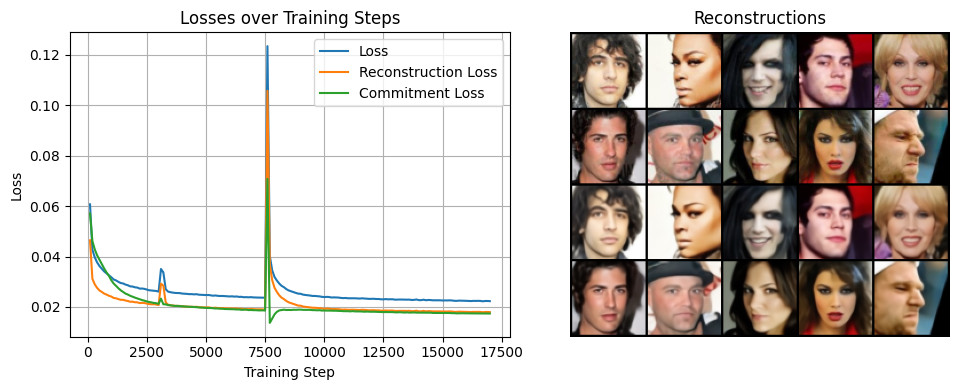

In [14]:
# training hyperparameters
EPOCHS = 0
LEARNING_RATE = 2e-4
LOG_INTERVAL = 100
SAVE_INTERVAL = 1000
SAVE_PATH = '/content/drive/MyDrive/vq_models/vq16_codebook_refresh' # THE SUFFIX '_{training_step}.pt' will be appended

# VQ-VAE training hyperparameters
BETA = 0.25

# optionally, resume training from a checkpoint
CONTINUE_FROM_CHECKPOINT = True #  # str | None
CHECKPOINT_PATH = '/content/drive/MyDrive/vq_models/vq16_codebook_refresh_17000.pt'

# optmizer and training state vars
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=2e-4)
train_state = {
    'losses_total': [],
    'losses_recon': [],
    'losses_commit': [],
    'logging_steps': [],
    'running_loss_total': 0.0,
    'running_loss_recon': 0.0,
    'running_loss_commit': 0.0,
    'steps': 0
}

if CONTINUE_FROM_CHECKPOINT:
    train_state = torch.load(CHECKPOINT_PATH, map_location=device)
    vq_vae.load_state_dict(train_state['model_state'])
    optimizer.load_state_dict(train_state['optmiizer_state'])
    print(f'Checkpoint loaded. Resuming from training step {train_state['steps']}.')

# training loop
print(f'{strftime('%H:%M:%S')} Begin Training')
end_step = train_state['steps'] + len(dataloader) * EPOCHS
vq_vae.train()
for epoch in range(EPOCHS):
    for batch_idx, batch in enumerate(dataloader):
        # training step
        images, _ = batch
        images = images.to(device)

        reconstruction_loss, commitment_loss = vq_vae(images)
        loss = reconstruction_loss + BETA * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_state['steps'] += 1
        train_state['running_loss_total'] += loss.item()
        train_state['running_loss_recon'] += reconstruction_loss.item()
        train_state['running_loss_commit'] += commitment_loss.item()

        # logging step
        if train_state['steps'] % LOG_INTERVAL == 0:
            avg_loss_total = train_state['running_loss_total'] / LOG_INTERVAL
            avg_loss_recon = train_state['running_loss_recon'] / LOG_INTERVAL
            avg_loss_commit = train_state['running_loss_commit'] / LOG_INTERVAL
            train_state['running_loss_total'] = 0.0
            train_state['running_loss_recon'] = 0.0
            train_state['running_loss_commit'] = 0.0
            train_state['losses_total'].append(avg_loss_total)
            train_state['losses_recon'].append(avg_loss_recon)
            train_state['losses_commit'].append(avg_loss_commit)
            train_state['logging_steps'].append(train_state['steps'])
            with torch.no_grad():
                p = vq_vae.quantizer.N / vq_vae.quantizer.N.sum() * NUM_EMBEDDINGS
            print(f'{strftime('%H:%M:%S')} TRAINING Step [{train_state['steps']}/{end_step}]; Loss: {avg_loss_total:.6f}; Recon: {avg_loss_recon:.6f}; Commit: {avg_loss_commit:.6f}; Usage (min/med/max/dead): {p.min().item():.4f}, {p.median().item():.2f}, {p.max().item():.2f}, {torch.sum(p < 0.001)}')

        # saving step
        if train_state['steps'] % SAVE_INTERVAL == 0 or (epoch == EPOCHS - 1 and batch_idx == len(dataloader) - 1):
            train_state['model_state'] = vq_vae.state_dict()
            train_state['optmiizer_state'] = optimizer.state_dict()
            model_save_path = f'{SAVE_PATH}_{train_state['steps']}.pt'
            torch.save(train_state, model_save_path)
            print(f'{strftime('%H:%M:%S')} Checkpoint saved at step {train_state['steps']} to {model_save_path}')

            # visualize reconstructions
            grid_x = 5
            grid_y = 2
            samples, _ = next(iter(dataloader))
            samples = samples[:grid_x * grid_y // 2].to(device)

            vq_vae.eval()
            reconstructed = vq_vae.reconstruct(samples)
            vq_vae.train()
            images = torch.cat((samples, reconstructed), dim=0)
            img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

            plt.title(f'Reconstructions at step {train_state['steps']}')
            plt.axis('off')
            plt.imshow(img.permute(1,2,0).cpu())
            img_save_path = f'{SAVE_PATH}_{train_state['steps']}_reconstructions.png'
            plt.savefig(img_save_path)
            plt.show()

print(f'Training complete.')

# Prepare reconstructions
grid_x = 5
grid_y = 4
samples, _ = next(iter(dataloader))
samples = samples[:grid_x * grid_y // 2].to(device)

vq_vae.eval()
reconstructed = vq_vae.reconstruct(samples)
images = torch.cat((samples, reconstructed), dim=0)
img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curves
axes[0].plot(train_state['logging_steps'], train_state['losses_total'], label='Loss')
axes[0].plot(train_state['logging_steps'], train_state['losses_recon'], label='Reconstruction Loss')
axes[0].plot(train_state['logging_steps'], train_state['losses_commit'], label='Commitment Loss')

axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].set_title('Losses over Training Steps')
axes[0].legend()
axes[0].grid(True)

# Reconstructions
axes[1].imshow(img.permute(1, 2, 0).cpu())
axes[1].set_title('Reconstructions')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Compute CelebA embeddings

In [15]:
from tqdm import tqdm

SAVE_PATH = '/content/drive/MyDrive/vq_models/celeba_vq_indices_uint16.pt'
celeba_indices = []

vq_vae.eval()
with torch.no_grad():
    for batch in tqdm(dataloader):
        images, _ = batch
        images = images.to(device)
        indices = vq_vae.compute_indices(images)
        celeba_indices.append(indices.view(-1, LATENT_W * LATENT_H).cpu())

print('Concatenating...')
celeba_indices = torch.cat(celeba_indices, dim=0)
print('Shape:', celeba_indices.shape)
celeba_indices = celeba_indices.to(torch.uint16)
print('Saving...')
torch.save(celeba_indices, SAVE_PATH)

100%|██████████| 1583/1583 [01:24<00:00, 18.67it/s]


Concatenating...
Shape: torch.Size([405198, 256])
Saving...


### Random Image Generation with Uniform Prior

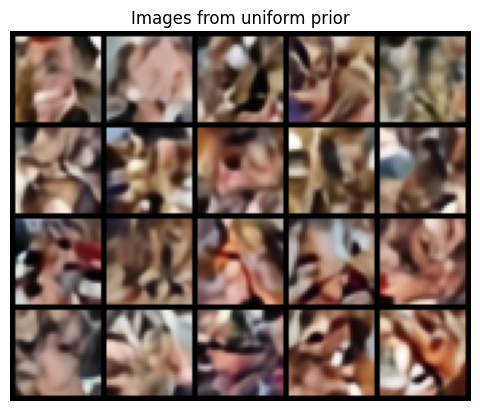

In [17]:
# visualize
grid_x = 5
grid_y = 4

vq_vae.eval()
samples = torch.randint(0, NUM_EMBEDDINGS, (grid_x*grid_y, 8, 8)).to(device)
with torch.no_grad():
    images = vq_vae.reconstruct_from_indices(samples)

img = torchvision.utils.make_grid(images, grid_x, normalize=True, value_range=(0, 1))
plt.title(f'Images from uniform prior')
plt.axis('off')
plt.imshow(img.permute(1,2,0).cpu())